In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_109207/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)


In [40]:
## MAIN SCRIPT
## **** CHANGE FILES AND DATES HERE


def rmse_time_series_plot_and_maps(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'

    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_5_40MEM_individual_ens_member_20110101_20110601/mean_output_gues/out.nc'

    ## ERA5 crash tests
    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights_MEM1_eq_MEM2/mean_output/out.nc'
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_crash_ens_members_test/mean_output/out.nc'

    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/TROY_ERA5_RESULTS_TEST2/mean_output/out.nc'
#     analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/iterative1_speedystatesfixed_offbyonebugfixed_hybrid_1_5_1_3/mean.nc'
    ### THIS IS THE OLD Hybrid MEAN 1.3,1.3 ## BEFORE BUGG FIXES
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal/mean/mean.nc'
    
    ### ERA5 
#     analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_weights_sourcecodeupdated_1_20_24/mean_output/out.nc'
#     analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_weights_1.7covariance_sourcecodeupdated_bugs/mean_output/out.nc'
    
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_retest_1_19_24/mean_output/out.nc'
    

    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
    enddate = datetime(2011,6,1,0)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4
    
    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .2:
        level_in_era = 2
    level_era = level_in_era

    var_da = variable_speedy
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    timestep_6hrly = 6


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
    temp_500_nature = ds_nature.values

    ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
    ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    temp_500_analysis = ds_analysis_mean

    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    # temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
    # temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values



    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    #find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    smallest_index = min(speedy_index,nature_index,hybrid_index)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    else:
        length = hybrid_index
    print('the smallest length is',length)

    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    # global_average_ensemble_spread_hybrid = np.zeros((length))
    # global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))

    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    for i in range(length):
        analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
        analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
        analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #     global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
    #     global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')

    # FOR DEALING WITH HOURLY RES ERA5 REANAL (((i*6)))

    # for i in range(length):
    #     analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis[i,:,:],lats)
    #     analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis_speedy[i,:,:],lats)
    #     #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    #     analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i*6,:,:]
    #     analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i*6,:,:]
    #     #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])
    print('Done.')  
    
    ############################
    # LOAD TROYS MEAN ANAL

    # Define the base path for the files
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal'
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights/'

    ### ERA 5 crash test
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/'
#     troy_anal_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/mean_output/out.nc'
    ### ERA5 1 year run worked path
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_weights_1.7covariance_sourcecodeupdated_bugs/'
    
    #### HYBRID NEW 1_3_1_3
    hybrid_base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_retest_1_19_24/'

    # Define the variable name, level, and time slice
    start_year = 2011
    end_year = 2011

    # startdate = datetime(2011,1,1,0)
    # enddate = datetime(2011,6,1,0)
    time_slice = slice(startdate,enddate)

    # level = 0.95 #0.2#0.95#0.51
    # level_era = 7 #2#7 #4

    # var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
    # var_da =  't'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    
    ## ADDING MEAN of Hybrid
    path_mean_anal_hybrid_retest = hybrid_base_path + 'mean_output/out.nc'
    ds_mean_anal_hybrid_retest_1_3_1_3 = xr.open_dataset(path_mean_anal_hybrid_retest)[var_da].sel(lev=level, time=time_slice)
    
     
#     # Create an empty list to store the datasets
#     ds_list = []

#     # ens member list
#     ens_member_list = range(1,40+1)
# #     print("opening all files...")
#     # Loop through the member numbers and read in the corresponding files
#     for member_number in ens_member_list:
#         file_path = f'{base_path}/{member_number:03d}_output/out.nc'
#         # file_path = f'{base_path}/{member_number:03d}_output/{member_number:03d}.nc'
#         ds = xr.open_dataset(file_path)[var_da].sel(lev=level, time=time_slice)
#         ds_list.append(ds)
#     print('shape test =', np.shape(ds_list))
    
    
    
#     ds_anal_troy = xr.open_dataset(troy_anal_path)[var_da].sel(lev=level, time=time_slice)
#     print('shape test =', np.shape(ds_anal_troy))
    
    # print('ds_list[0] =',ds_list[0])

    # Assign each element in ds_list to be called ds_member_{i}
    # for i, ds in enumerate(ds_list, start=1):
    #     globals()[f'ds_member_{i}'] = ds

    # print(ds_member_1) 

    lats = ds_nature.Lat

    # analysis_error is for maps, see its a 3d array, 
    # MAKING analysis_rmse now

    print('MAKING zeros arrays..')
#     quantity_of_ens_members = 40
#     analysis_rmse_object = np.zeros((quantity_of_ens_members, length))
    
#     anal_rmse_troy = np.zeros((length))
#     anal_error_troy = np.zeros((length,ygrid,xgrid))
    anal_mean_error_hybrid_1_3_1_3 = np.zeros((length,ygrid,xgrid))
    anal_mean_rmse_hybrid_1_3_1_3 = np.zeros((length))
    
    # check shape, yes they are equal and vibing
    # print('new = ',np.shape(analysis_rmse_object[0]))
    # print('old = ', np.shape(analysis_rmse_1))

#     print('looping through each ERA5 ens_member at every timestep..')
#     counter = 0
#     for member_number in range(0,40):
#         # loop through each timestep
#         counter = counter + 1
#         print('MEM counter = ',counter)
#         for l in range(length):
#     #     for l in range(length):
#             analysis_rmse_object[member_number,l] = latituded_weighted_rmse(temp_500_nature[l,:,:],ds_list[member_number][l,:,:],lats)
    
    print('looping through troy anal and hybrid 1.3,1.3 ..')
    for i in range(length):
#         anal_error_troy[i,:,:] = ds_anal_troy[i,:,:] - temp_500_nature[i,:,:]
#         anal_rmse_troy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_anal_troy[i,:,:],lats)
        anal_mean_error_hybrid_1_3_1_3[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
        anal_mean_rmse_hybrid_1_3_1_3[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:],lats)
        
        
    ##### and calc for mem 1 with length == 3:
    # analysis_rmse_mem1 = latituded_weighted_rmse(temp_500_nature[3,:,:],ds_list[1][3,:,:],lats)
    # print(analysis_rmse_mem1)
    #####

    # print('analysis_rmse_object[0] =',analysis_rmse_object[0])
    # print('analysis_rmse_object[39] =',analysis_rmse_object[39])    

    print('Done with analysis.')
    
    #########################################################
    # MAKE MAP FROM ABOVE 

    ''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
    ####### WHICH AVGERAGE ERROR DO YOU WANT?? I want the analysis error of the mean ERA5
    # analysis_error
#     averaged_error = np.average(abs(anal_mean_error_hybrid_1_3_1_3[24::,:,:]),axis=0)
    averaged_error = np.average(abs(analysis_error[24::,:,:]),axis=0)
    averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)

    lat = ds_analysis_mean.lat.values
    lon = ds_analysis_mean.lon.values

    lons2d, lats2d = np.meshgrid(lon,lat)

    print('Now plotting and meshing...')

    ''' Multiply averaged_error by 1000 for spec_humid only'''

    if var_era == 'Temperature':
        units='(K)'
    if var_era == 'Specific_Humidity':
        units='(g/kg)'
    if var_era == 'V-wind':
        units='(m/s)'
    if var_era == 'U-wind':
        units='(m/s)'
    print(units)
    if level == .95:
        title_level = 'Low Level '
    if level == .2:
        title_level = '200 hPa '

    if var_era == 'Specific_Humidity':
        title_var_era = 'Specific Humidity'
    if var_era == 'V-wind':
        title_var_era = "Meridional Wind"
    if var_era == 'Temperature':
        title_var_era = 'Temperature'
    if var_era == 'U-wind':
        title_var_era = 'Zonal Wind'
    print(title_var_era)

    if level == .95 and var_era == 'Temperature':
        adapted_range = np.arange(0,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)

    if level == .2 and var_era == 'Temperature':
#         adapted_range = np.arange(0,.1,.001)
#         adapted_difference_range = np.arange(-.05,.05,.001)
        adapted_range = np.arange(0,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)

    if level == .95 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(0,3,.05)
        adapted_difference_range = np.arange(-2,2,.001)

    if level == .2 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(0,.1,.001)
        adapted_difference_range = np.arange(-.05,.05,.001)

    if level == .2 and var_era == 'V-wind':
        adapted_range = np.arange(0,10.05,.05)
        adapted_difference_range = np.arange(-2,2.1,.05)
    if level == .95 and var_era == 'V-wind':
        adapted_range = np.arange(0,10.05,.05)
        adapted_difference_range = np.arange(-2,2.1,.05)
    if level == .95 and var_era == 'U-wind':
        adapted_range = np.arange(0,10.05,.05)
        adapted_difference_range = np.arange(-2,2.1,.05)
    if level == .2 and var_era == 'U-wind':
        adapted_range = np.arange(0,10.05,.05)
        adapted_difference_range = np.arange(-2,2.1,.05)
    
    ### ADAPT TO 2 small on top 1 big plot below
    
#     fig = plt.figure(figsize=(8,12))
#     fig = plt.figure(figsize=(10,8))

#     fig.suptitle('LETKF Analysis Error\n' + title_level +  title_var_era + '\n Jan 1, 2011 to June 1, 2011')

#     gs = fig.add_gridspec(2,2, width_ratios=[1, 1], height_ratios=[1.3, 3])
#     ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
#     ''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
# #     ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
#     ax1.coastlines()
    
#     # Mulitply 1000 for spec humid
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
#     else: 
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
        
#     cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)

# #     plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
#     ax1.set_title('ERA5 trained Hybrid 1.7') #1.3

#     '''ax2 ===>  makes plot of speedy letkf analysis error '''
# #     ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
#     ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
#     ax2.coastlines()
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
#     plt.colorbar(cf,label=units,fraction=0.02, pad=0.04)
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
#     ax2.set_title('SPEEDY')

#     diff = averaged_error - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     '''ax3 ==> Makes map of difference of hybrid and speedy '''
#     ax3 = fig.add_subplot(gs[1, :],projection=ccrs.PlateCarree())
# #     ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
#     ax3.coastlines()
#     ax3.set_title('Difference (Hybrid - SPEEDY)')
    
#     # high_level_difference_range = np.arange(-.05,.05,.001)
#     # low_level_difference_range = np.arange(-5,5,.05)

#     cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=adapted_difference_range,extend='both',cmap='seismic')
#     plt.colorbar(cf,label=units,fraction=0.02, pad=0.04)
#     plt.tight_layout(pad=1.0)
# #     plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
# #     plt.show()
    
#     # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
#     filename = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}.png"
#     print(filename)
    # Save the figure with the generated filename
#     plt.savefig(filename,dpi=1200)

    
#     #####################################
#     if var_era == 'Temperature':
#         units='(K)'
#     if var_era == 'Specific_Humidity':
#         units='(g/kg)'
#     if var_era == 'V-wind':
#         units='(m/s)'
#     if var_era == 'U-wind':
#         units-'m/s'
#     print(units)
#     if level == .95:
#         title_level = 'Low Level '
#     if level == .2:
#         title_level = '200 hPa '
# #     print(title_level)
    
#     if var_era == 'Specific_Humidity':
#         title_var_era = 'Specific Humidity'
#     if var_era == 'V-wind':
#         title_var_era = "Meridional Wind"
#     if var_era == 'Temperature':
#         title_var_era = 'Temperature'
#     print(title_var_era)
    
    # code for plot every ensemble member

    # MAKE TIME SERIES for each ensemble member

    x = np.arange(0,length)
    base = datetime(2011,1,1,0)

    plt.figure(figsize=(12,6))
    date_list = [base + timedelta(days=x/4) for x in range(length)]
    ### PLOT ENS MEMBERS 
    
    # make colors for 40 member ens
#     from matplotlib.colors import LinearSegmentedColormap
#     start_color = np.array([1.0, 0.8, 0.8])  # Light Red (RGB values)
#     end_color = np.array([0.5, 0.0, 0.0])   # Dark Red (RGB values)
#     # Create a colormap with 40 colors by linearly interpolating between start and end colors
#     cmap = LinearSegmentedColormap.from_list("custom_colormap", np.linspace(start_color, end_color, 40))
#     # Get a list of 40 different colors from the colormap
#     num_colors = 40
#     colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

#     for each_member in range(0,40):
#         plt.plot(date_list,analysis_rmse_object[each_member],linewidth=.45,color=colors[each_member],label=each_member+1)
    # ALSO Average of MEAN LINE
    width = 1
    plt.plot(date_list,anal_mean_rmse_hybrid_1_3_1_3,color='red',lw=width,label="Hybrid")
    plt.axhline(y=np.average(anal_mean_rmse_hybrid_1_3_1_3[20::]),color='red',lw=width, linestyle='--',label="Average Hybrid")
    
    #### TROY
#     plt.plot(date_list,anal_rmse_troy,linewidth=.45,color='red',label='TROY NEW HYBRID 1.5,1.3 Mean')
#     plt.axhline(y=np.average(anal_rmse_troy[20::]), color='red',lw=.6, linestyle='--',label="Average TROY NEW HYBRID 1.5,1.3 Mean")
    
    plt.plot(date_list,analysis_rmse_speedy,label='Speedy',linewidth=width,color='blue')    
    plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='blue',lw=width, linestyle='--',label="Average Speedy")
    
#     plt.plot(date_list,analysis_rmse,label='Speedy trained Hybrid 1.3 retrain',linewidth=0.45,color='green')
#     plt.axhline(y=np.average(analysis_rmse[20::]), color='green',lw=.6, linestyle='--',label="Average Speedy trained Hybrid 1.3 retrain")

#     plt.plot(date_list,analysis_rmse_object[0],linewidth=.45,color='green',label='MEM1 in GREEN')
#     plt.axhline(y=np.average(analysis_rmse[20::]), color='r',lw=width, linestyle='--',label="Average RMSE 1st Iteration Hybrid 1.5,1.3")
#     plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b',lw=width, linestyle='--',label="Average RMSE SPEEDY 1.3")

    plt.title('LETKF Analysis Error\n'+ title_level + title_var_era,fontsize=14)
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('RMSE',fontsize=12)
    plt.xlim([datetime(2011,1,1,0),datetime(2011,6,1,0)])
    # plt.ylim(1.25,2.75)
    
    #####
    if level == .95 and var_era == 'Temperature':
        plt.ylim(1.9,2.75)
        
    if level == .2 and var_era == 'Temperature':
        plt.ylim(1,3.5)

    if level == .95 and var_era == 'Specific_Humidity':
        plt.ylim(.0011,.0019)

    if level == .2 and var_era == 'Specific_Humidity':
        plt.ylim(3e-5,6e-5)

    if level == .2 and var_era == 'V-wind':
        plt.ylim(3,5.5)
        
    if level == .95 and var_era == 'V-wind':
        plt.ylim(2.5,3.75)
        
    if level == .95 and var_era == 'U-wind':
        plt.ylim(2.5,3.75)
        
    if level == .2 and var_era == 'U-wind':
        plt.ylim(3,6)
    #####
    
#     plt.legend(ncol=1,loc='center right', bbox_to_anchor=(1.3, 0.5))
    plt.legend()
    plt.grid(color='grey', linestyle='--', linewidth=.3)
#     plt.show()
      # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
    filename = f"Time_Series_of_level_{level_in_speedy}_variable_{variable_speedy}.png"
    # Save the figure with the generated filename
    plt.tight_layout()
#     plt.savefig(filename,dpi=1200)
    plt.show()
    

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Specific_Humidity
at level = 0.95
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(g/kg)
Specific Humidity


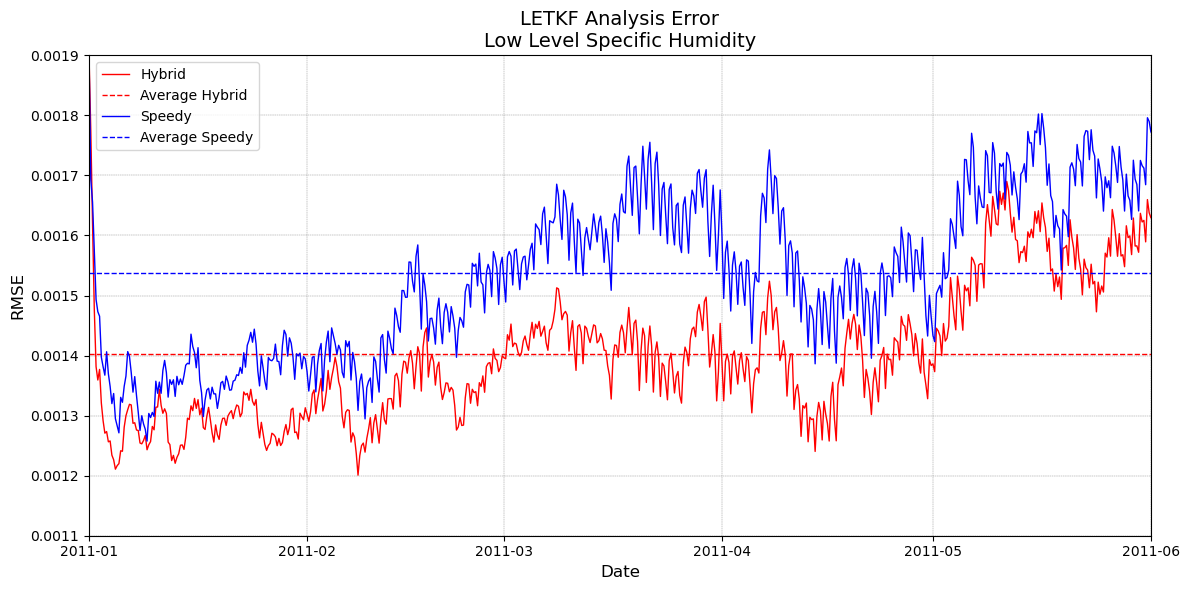

In [41]:
# TEST CELL an individual variable/level combination
rmse_time_series_plot_and_maps(.95,'q')

U-wind
you selected for variable = U-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = U-wind
at level = 0.95
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(m/s)
Zonal Wind


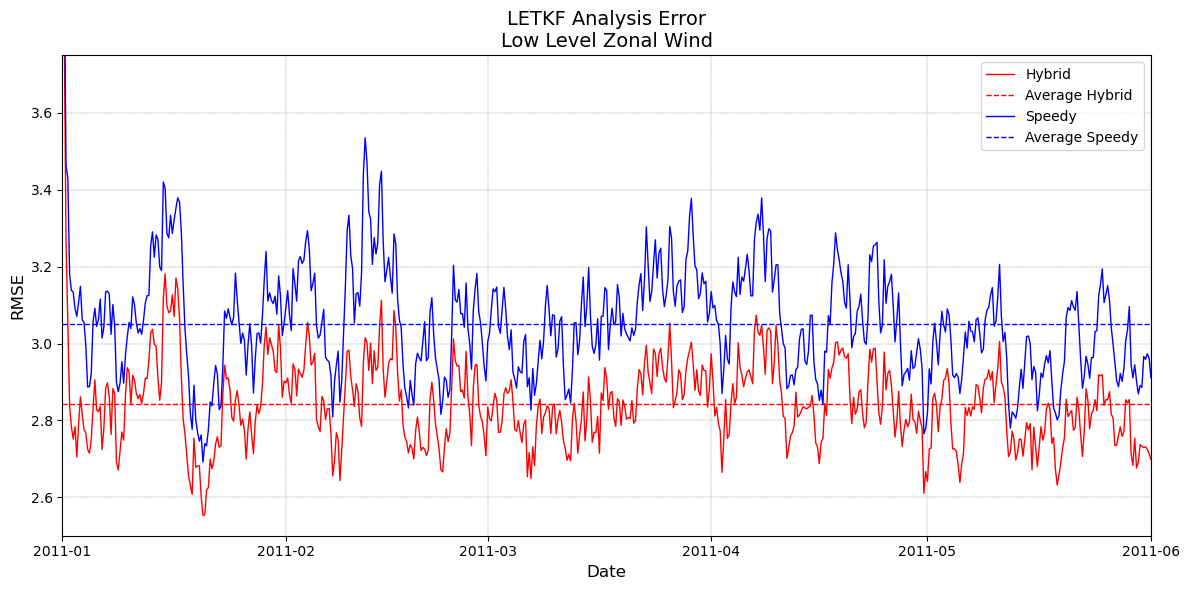

Temperature
you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Temperature
at level = 0.95
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(K)
Temperature


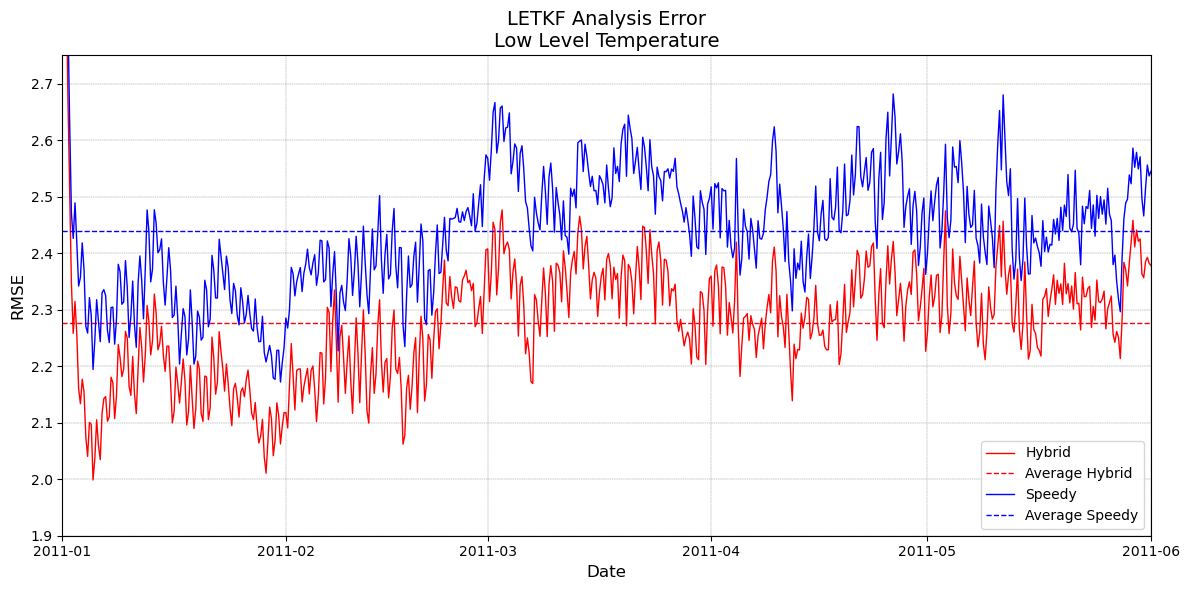

V-wind
you selected for variable = V-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = V-wind
at level = 0.95
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(m/s)
Meridional Wind


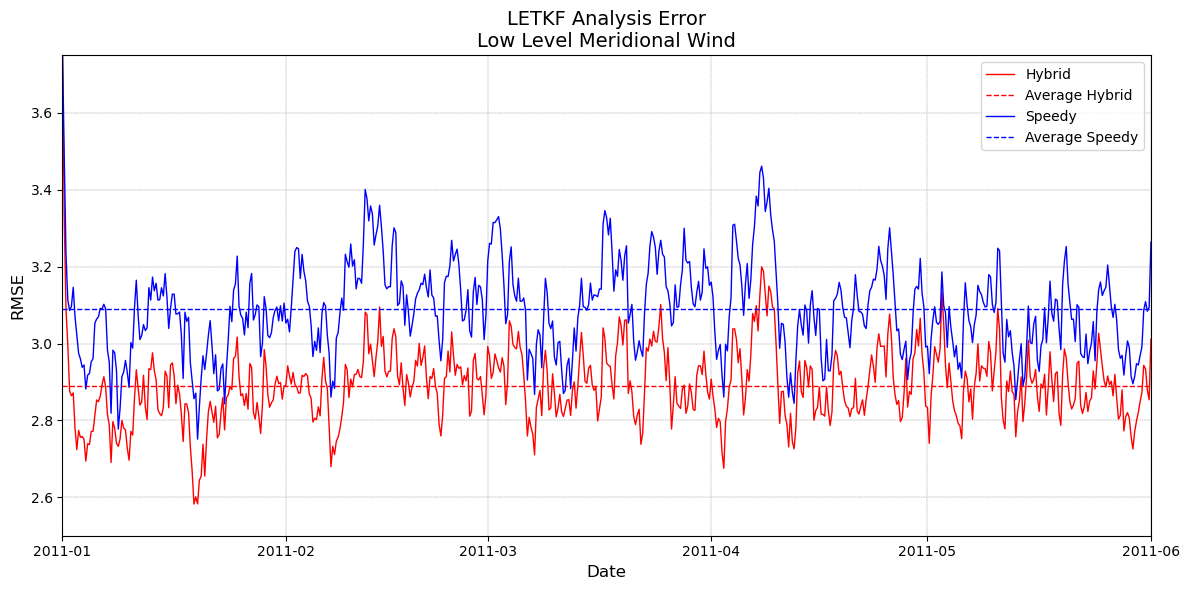

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Specific_Humidity
at level = 0.95
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(g/kg)
Specific Humidity


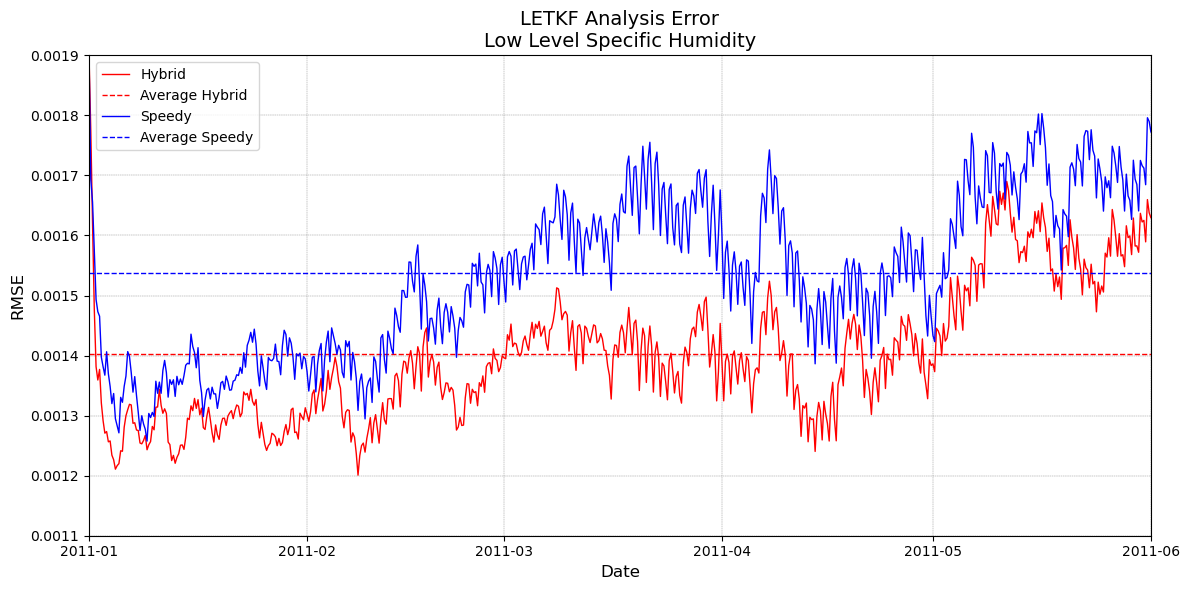

U-wind
you selected for variable = U-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = U-wind
at level = 0.2
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(m/s)
Zonal Wind


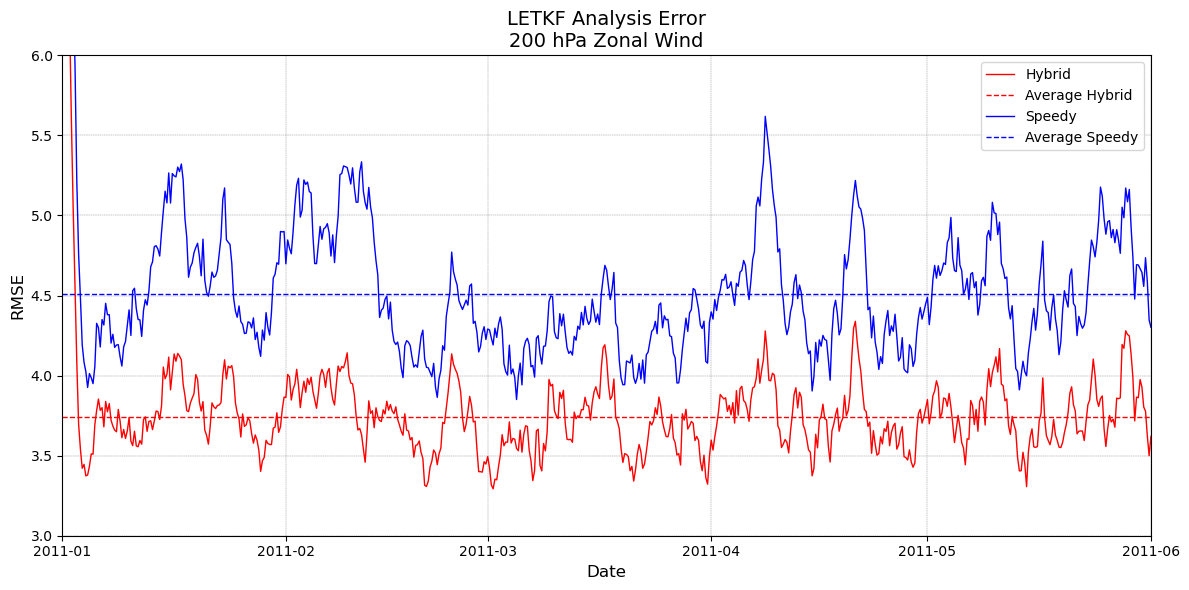

Temperature
you selected for variable = Temperature
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Temperature
at level = 0.2
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(K)
Temperature


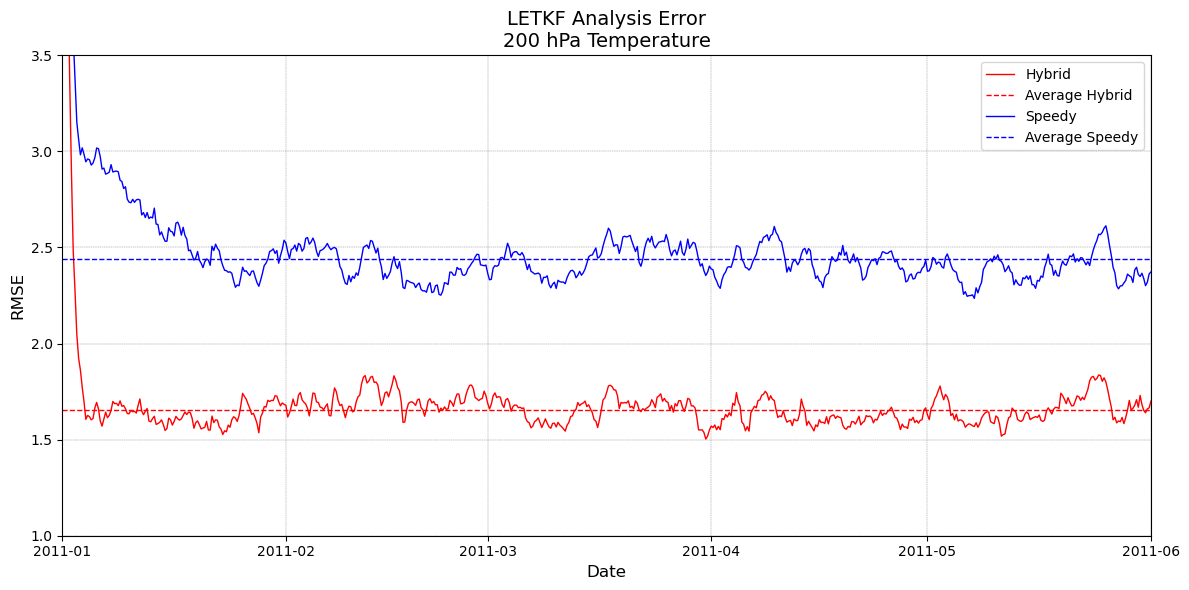

V-wind
you selected for variable = V-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = V-wind
at level = 0.2
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(m/s)
Meridional Wind


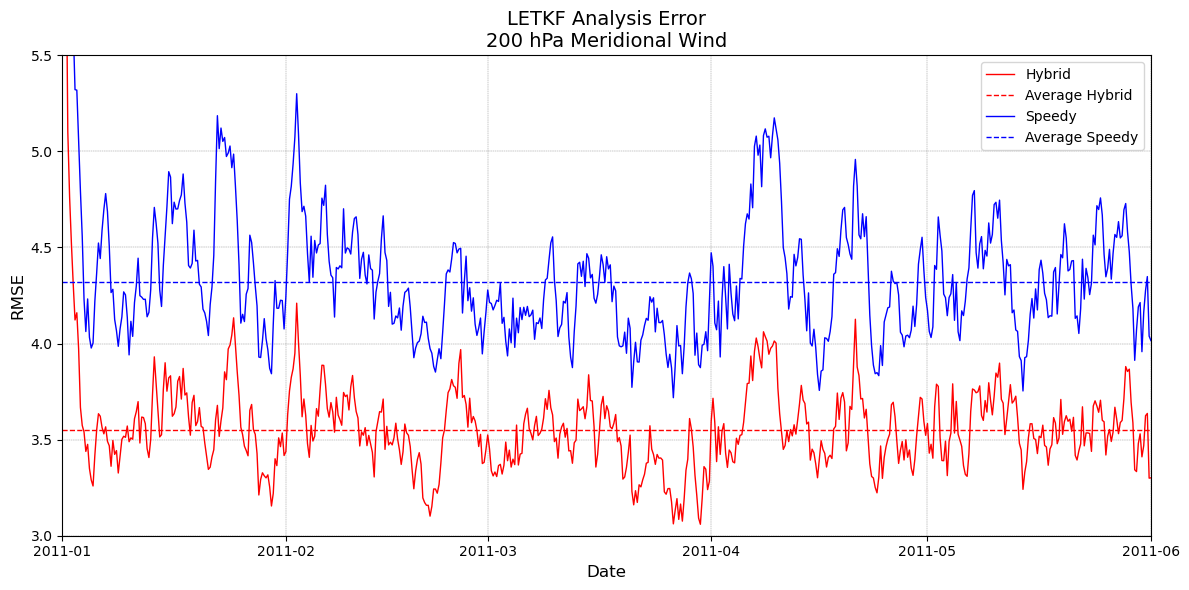

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (605, 48, 96)
hybrid shape =  (605, 48, 96)
the smallest length is 605
(605, 48, 96)
(605, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.
you selected for variable = Specific_Humidity
at level = 0.2
MAKING zeros arrays..
looping through troy anal and hybrid 1.3,1.3 ..
Done with analysis.
Now plotting and meshing...
(g/kg)
Specific Humidity


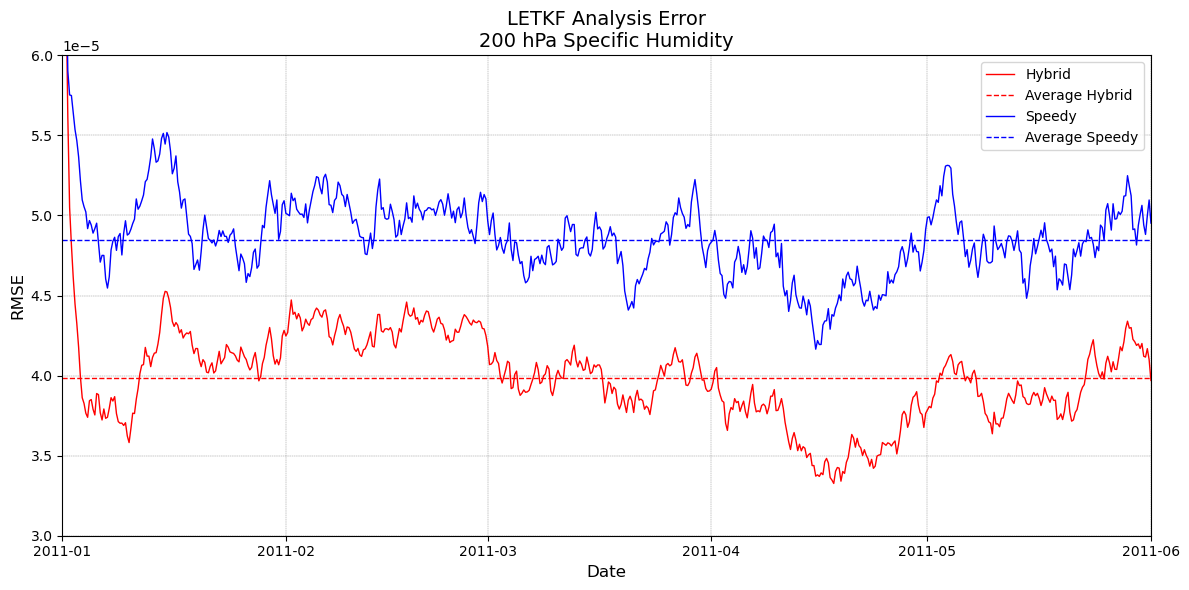

In [42]:
## works!
## need to change file and dates in function above before running this cell


## LOOP THROUGH FUNCTION

# FUNCTION INPUTS

level_list_speedy = [.95,.2]
variable_list_speedy = ['u','t','v','q']

for level in level_list_speedy:
    for variable in variable_list_speedy:
        rmse_time_series_plot_and_maps(level,variable)

